# ARIMA Model for National Retail Gas Price

### Table of Contents
* Set-up
* Differentiation
* Autocorrelation
* Partial Autocorrelation
* Model Choice: ARIMA(3,1,0)
* Fit Model
* Testing in Training Period
  + Metric 1: Correlation of Predicted and Actual Log Return
  + Metric 2: Precision, Recall, and Accuracy of Predicting Price Move Directions
* Testing in Cross-Validation Period
  + Metric 1: Correlation of Predicted and Actual Log Return
  + Metric 2: Precision, Recall, and Accuracy of Predicting Price Move Directions
* Comparison to Multivariate Rolling Regression

## Set-up

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.stats.stattools import durbin_watson
from sklearn.linear_model import LinearRegression, LassoLars, lars_path, lasso_path
from sklearn.preprocessing import normalize
from statsmodels.tsa.arima_model import ARIMA
%matplotlib inline

/Users/ChingYunH/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Read retail gas prices from csv.

In [2]:
def custom_read_csv(filename):
    df = pd.read_csv(filename)
    df['date'] = pd.to_datetime(df['date'])
    return df.set_index('date')

In [3]:
# note that all prices are released on Monday, dayofweek = 0
national_price = custom_read_csv('national.csv').dropna()
state_price = custom_read_csv('state.csv').dropna()
state_price = state_price.drop('Unnamed: 10', axis=1).dropna()
city_price = custom_read_csv('city.csv').dropna()
price = pd.concat([national_price, state_price, city_price], axis=1)

The training period is 1992 - 2010. Save 2011 - 2016 for cross-validation.

In [4]:
trainingdates = np.intersect1d(price.index, pd.date_range('1992-01-01','2010-12-31'))

## Differentiation

The price series is not a stationary time series. Augmented Dicken Fuller test fails to reject the non-stationary null hypothesis.

In [5]:
pvalue = adfuller(price.national[trainingdates])[1]
pvalue

0.68376529942817021

Differentiate the series. (Take approximate log return.)

In [6]:
logreturn = ((price.national - price.national.shift(1)) / price.national.shift(1)).dropna().rename('logreturn')

In [7]:
pvalue = adfuller(logreturn[trainingdates])[1]
pvalue

5.1087292642223889e-12

The first order difference is stationary.

Therefore, we should choose d = 1 in the ARIMA(p,d,q) model. 

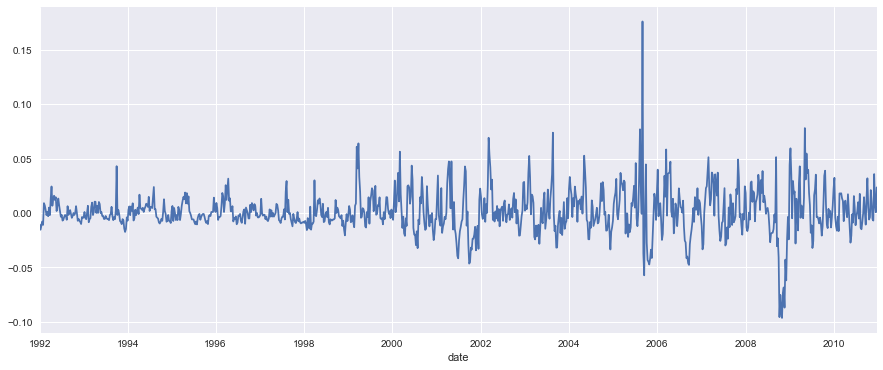

In [8]:
logreturn[trainingdates].plot(figsize=(15,6))
plt.show()

## Autocorrelation

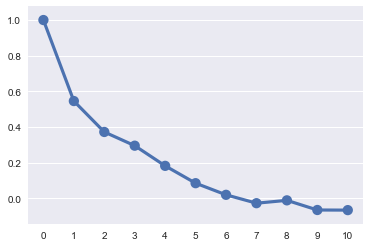

In [9]:
g = sns.pointplot(x=np.arange(11), 
                  y=acf(logreturn, nlags=10)) 

* Autocorrelation slowly tails off.

## Partial Autocorrelation

Next, we look at partial autocorrelation of residues. Partial autocorrelation gives the partial correlation of a time series with its own lagged values, controlling for the values of the time series at all shorter lags. 

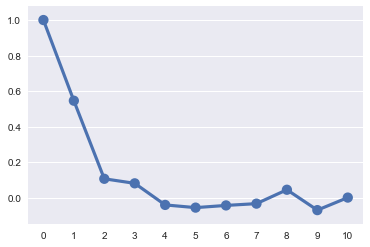

In [10]:
g = sns.pointplot(x=np.arange(11), y=pacf(logreturn, nlags=10))    

* Partial autocorrelation cuts off after lag 3. 

## Model Choice: ARIMA(3,1,0)

Partial autocorrelation and autocorrelation together examine whether there is a moving average component, and whether there is an autoregressive component.

* In AR(p) model (no moving average), $$X_t - a_1X_{t-1} - \cdots a_pX_{t-p} = \epsilon_t.$$ Theoretically, partial autocorrelation cuts off at lag $p$, while autocorrelation slowly dies down. 

* In MA(q) model (only moving average no autoregression), $$X_t = \epsilon_t + \theta_1 \epsilon_{t-1} + \cdots + \theta_q \epsilon_{t-q}.$$ Theoretically, autocorrelation cuts off at lag $q$, while partial autocorrelation slowly dies down.

* In ARMA(p,q) model with both moving average and autoregression, both autocorrelation and partial autocorrelation slowly die down.

Based on observed autocorrelation and partial autocorrelation, let's try ARIMA(3,1,0) model.

## Fit Model

In [11]:
ts = price.national.loc[trainingdates]
model = ARIMA(ts, order=(3,1,0)).fit()
print model.summary()
price_prediction = model.predict()

                             ARIMA Model Results                              
Dep. Variable:             D.national   No. Observations:                  990
Model:                 ARIMA(3, 1, 0)   Log Likelihood                1857.126
Method:                       css-mle   S.D. of innovations              0.037
Date:                Sat, 16 Sep 2017   AIC                          -3704.253
Time:                        17:08:36   BIC                          -3679.764
Sample:                    01-13-1992   HQIC                         -3694.941
                         - 12-27-2010                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0021      0.003      0.624      0.533      -0.005       0.009
ar.L1.D.national     0.4544      0.031     14.430      0.000       0.393       0.516
ar.L2.D.national     0.0583 

In [12]:
a1, a2, a3 = model.arparams

## Testing in Training Period

In [13]:
logreturn_prediction = a1 * logreturn.shift(1) + a2 * logreturn.shift(2) + a3 * logreturn.shift(3)
logreturn_prediction = logreturn_prediction.rename('predicted')

### Metric 1: Correlation between predicted and actual log returns

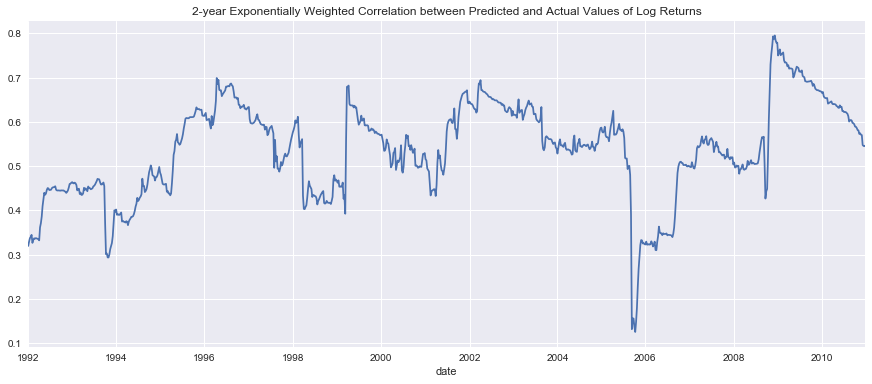

In [14]:
corr = pd.concat([logreturn, logreturn_prediction], axis=1).ewm(span=52 * 2).corr().dropna()
corr = corr.unstack()['logreturn']['predicted']
corr[trainingdates].plot(
    figsize=(15,6), title='2-year Exponentially Weighted Correlation between Predicted and Actual Values of Log Returns')
plt.show()

Again, as mentioned in the multivariate regression model testing, Hurrican Katrina in 2005 results in abnormal behavior.

### Metric 2: Precision, Recall, and Accuracy of Predicted Price Move Directions

#### Precision

In [15]:
1.0 * np.logical_and(logreturn[trainingdates] > 0, logreturn_prediction[trainingdates] > 0).sum() / \
    (logreturn_prediction[trainingdates] > 0).sum()

0.6472945891783567

#### Recall

In [16]:
1.0 * np.logical_and(logreturn[trainingdates] > 0, logreturn_prediction[trainingdates] > 0).sum() / \
    (logreturn[trainingdates] > 0).sum()

0.7161862527716186

#### Accuracy

In [17]:
1.0 * (logreturn[trainingdates] * logreturn_prediction[trainingdates] > 0).sum() / len(trainingdates)

0.6831483350151363

## Testing in Cross-Validation Period

In [18]:
cvdates = np.intersect1d(price.index, pd.date_range('2011-01-01','2016-12-31'))

### Metric 1: Correlation between predicted and actual log returns

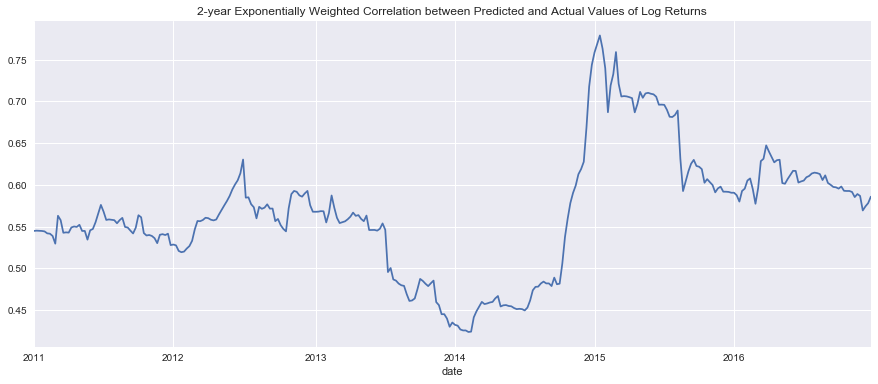

In [19]:
corr = pd.concat([logreturn, logreturn_prediction], axis=1).ewm(span=52 * 2).corr().dropna()
corr = corr.unstack()['logreturn']['predicted']
corr[cvdates].plot(
    figsize=(15,6), title='2-year Exponentially Weighted Correlation between Predicted and Actual Values of Log Returns')
plt.show()

### Metric 2: Precision, Recall, and Accuracy of Predicted Price Move Directions

#### Precision

In [20]:
1.0 * np.logical_and(logreturn[cvdates] > 0, logreturn_prediction[cvdates] > 0).sum() / \
    (logreturn_prediction[cvdates] > 0).sum()

0.684931506849315

#### Recall

In [21]:
1.0 * np.logical_and(logreturn[cvdates] > 0, logreturn_prediction[cvdates] > 0).sum() / \
    (logreturn[cvdates] > 0).sum()

0.7092198581560284

#### Accuracy

In [22]:
1.0 * (logreturn[cvdates] * logreturn_prediction[cvdates] > 0).sum() / len(cvdates)

0.7220447284345048

## Comparison to Multivariate Rolling Regression

* Performance in Training Period

| Model                            | Precision   | Recall     | Accuracy  |
| -------------                    |:-----------:|:----------:|:---------:|
| Multivariate Rolling Regression  | 62%         |   53%      | 48%       |
| ARIMA                            | 65%         |   72%      | 68%       |


* Performance in Cross-Validation 

| Model                            | Precision   | Recall     | Accuracy  |
| -------------                    |:-----------:|:----------:|:---------:|
| Multivariate Rolling Regression  | 66%         |   78%      | 72%       |
| ARIMA                            | 68%         |   71%      | 72%       |

Even though the ARIMA(3,1,0) model is better than multivariate regression in both metrics in training period, it does not have any significant advantage in cross-validation period.

In cross-validation, 
* The two models have the same accuracy and similar precision. 
* Multivariate rolling regression has higher recall.

This suggests ARIMA model overfits to the training period more than multivariate rolling regression. (This is expected because rolling regression only uses past data, while ARIMA is trained on the entire training period.)

That being said, the ARIMA model is simpler, and it does not need extra predictor data other than the time series itself.

In the next notebook, the two models are compared to logistic regression. Logistic regression is significantly better at classifying price move directions.